In [18]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add to utils.py: constillation, BER vs SNR, make plotting big signals faster, improve complex signal handling
- Verify that CFO and CPO are correctly applied
- Add carrier recovery and timing synchronization
- Add multipath effects to channel & equalizer
- Channel coding
- Time offset
- Framing? Detect start of frame


Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add utils.py for visualization (spectrum, constillation, BER vs SNR) and RRC filtering\n- Verify that CFO and CPO are correctly applied\n- Add carrier recovery and timing synchronization\n- Add multipath effects to channel & equalizer\n- Coding\n- Time offset\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [32]:
# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt

import importlib
import utils
importlib.reload(utils)
from utils import *


# Constants
SPS = int(10)                 # Large to see pulse shape well
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2)     # qpsk: 2 bits/sample
SNR_DB = 0


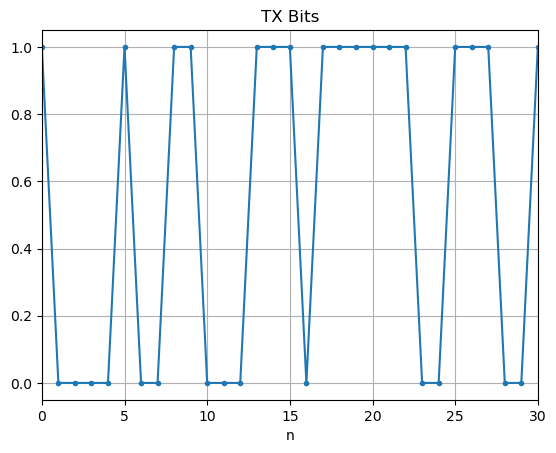

In [33]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
bit_pairs = bits_tx.reshape(-1, 2)

plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

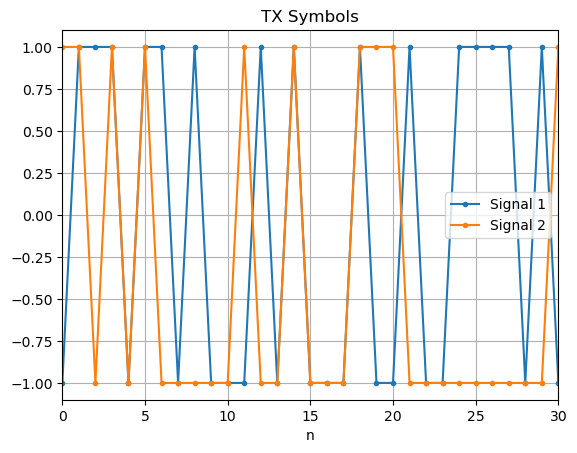

In [34]:
### QPSK modulation ###
bits_to_sym_map = {
    (0, 0):  1 + 1j,
    (0, 1):  1 - 1j,
    (1, 1): -1 - 1j,
    (1, 0): -1 + 1j,
}

sym_tx = np.array([bits_to_sym_map[tuple(pair)] for pair in bit_pairs])
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30])


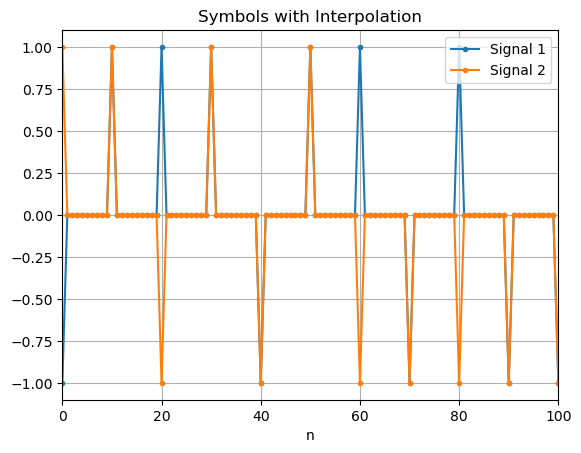

In [35]:
### Pulse filtering ###

# Interpolate by factor of SPS
sym_interp = np.zeros(N_SYMBOLS * SPS, dtype=complex)
for i, sym in enumerate(sym_tx):
    sym_interp[i*SPS] = sym

plot_signal(sym_interp.real, sym_interp.imag, title='Symbols with Interpolation', xlim=[0, 100])


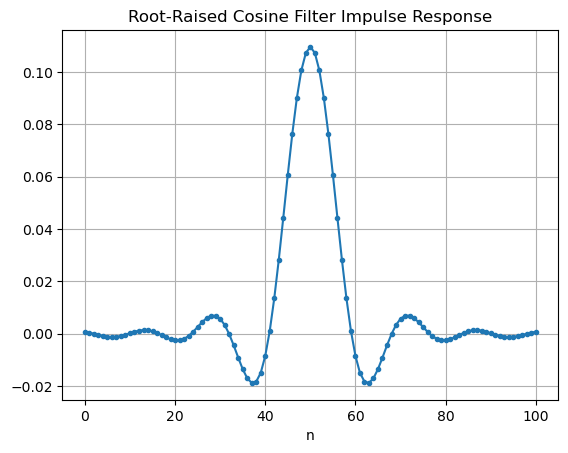

In [37]:
h_rrc = rrc_coef(Ts=SPS)

plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response')

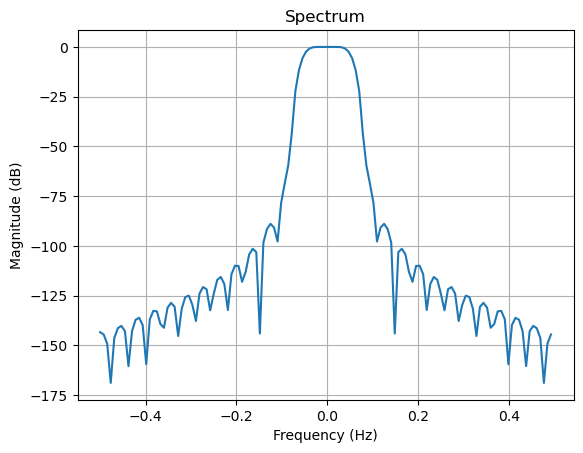

In [38]:
plot_spectrum(h_rrc)

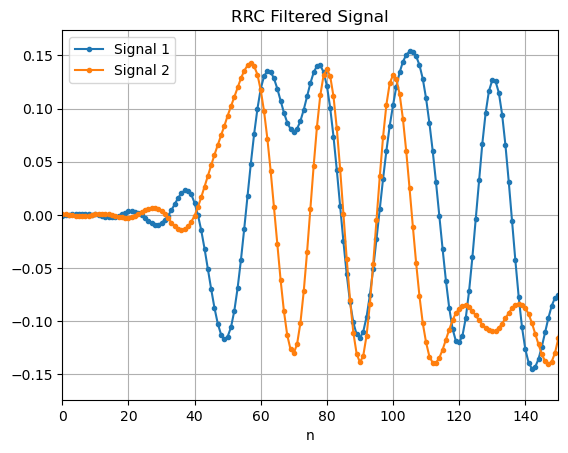

In [45]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_interp, h_rrc)
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150])

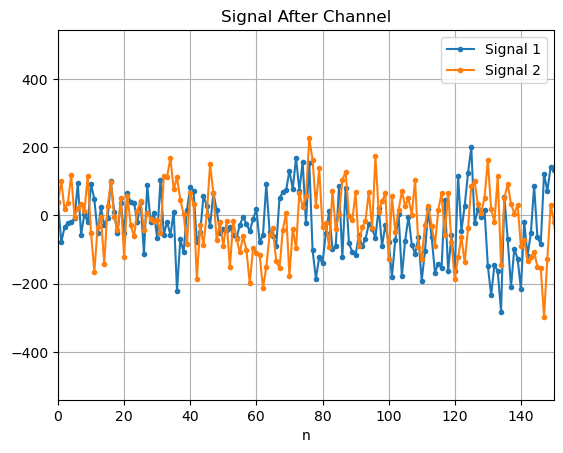

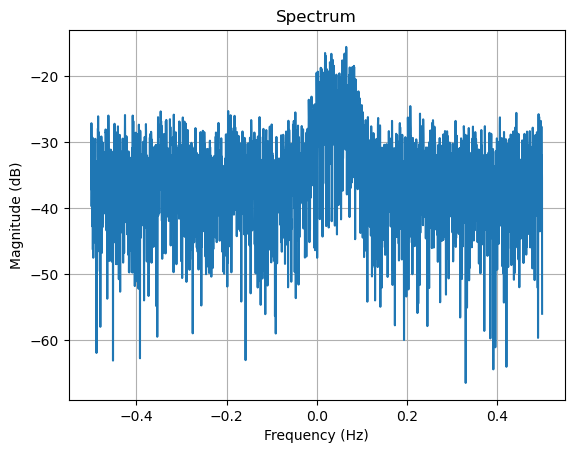

In [47]:
### Channel ###

# Carrier frequency and phase offset
abs_max_off = 0.01 * (2*np.pi)   # testing/realistic: 1-5%, aggressive: 10%
w_off = 2*abs_max_off*np.pi*np.random.rand() - abs_max_off  # [radians/sample]
p_off = 2*np.pi*np.random.rand()  # [radians]
n = np.arange(len(sig_tx))
sig_tx = sig_tx * np.exp(1j*w_off*n + p_off)

# AWGN
signal_power = np.mean(abs(sig_tx) ** 2)
noise_power = signal_power / (10**(SNR_DB / 10))
awgn = np.sqrt(noise_power / 2) * (np.random.normal(0, 1, len(sig_tx)) + 1j * np.random.normal(0, 1, len(sig_tx)))
sig_rx = sig_tx + awgn

# Visualize signal after channel
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150])
plot_spectrum(sig_rx, size=2**12)

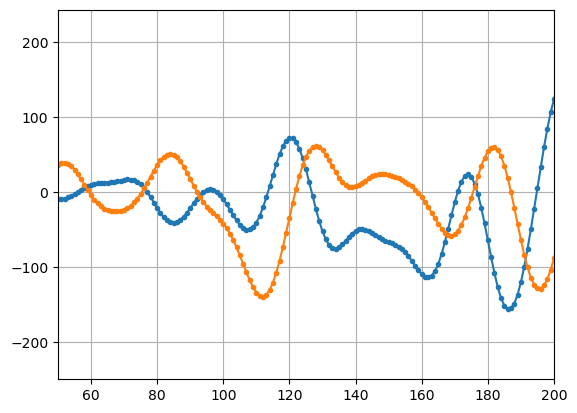

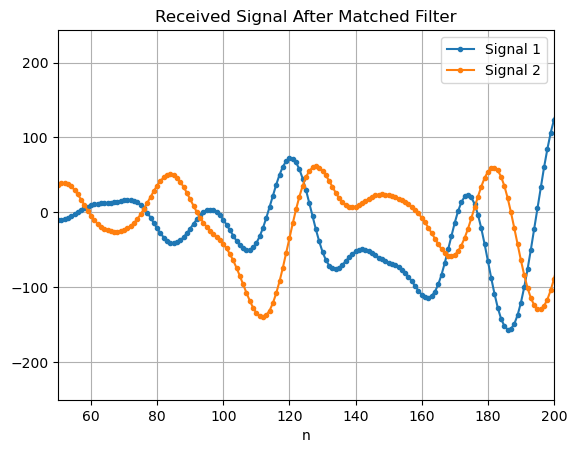

In [48]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

plt.plot(sig_matched.real, '.-')
plt.plot(sig_matched.imag, '.-')
plt.grid(True)
plt.xlim([50, 200])
plt.show()
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter')

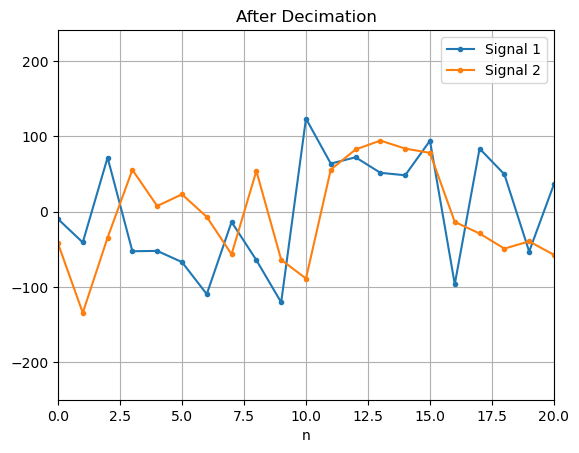

In [49]:
### Demodulation ###

# Remove extra shit from convolutions
sig_matched = sig_matched[100:-100]

# Decimate to 1 sps
sig_dec = np.empty(len(sig_matched) // 10, dtype=complex)
for i, samp in enumerate(sig_matched):
    if i % 10 == 0:
        sig_dec[i//10] = samp

plot_signal(sig_dec.real, sig_dec.imag, title='After Decimation', xlim=[0, 20])

In [50]:
# Looks good! 

# Decide on each symbol
sym_rx = np.empty(len(sig_dec), dtype=complex)
for i, sym in enumerate(sig_dec):
    if sym.real > 0 and sym.imag > 0: sym_rx[i] =  1 + 1j
    if sym.real > 0 and sym.imag < 0: sym_rx[i] =  1 - 1j
    if sym.real < 0 and sym.imag < 0: sym_rx[i] = -1 - 1j
    if sym.real < 0 and sym.imag > 0: sym_rx[i] = -1 + 1j

# Map each symbol to bits
sym_to_bits_map = {
    (1+1j) : [0, 0],
    (1-1j) : [0, 1],
    (-1-1j): [1, 1],
    (-1+1j): [1, 0],
}

bits_rx = np.concatenate([sym_to_bits_map[sym] for sym in sym_rx])

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 0.500153
